# Population Fluidity

To Do: 
Create connection to data source and perform basic EDA

[Variable information for ACS data](https://www.census.gov/data/developers/data-sets/acs-1year/notes-on-acs-api-variable-types.html)

[Guidance for Developers](https://www.census.gov/data/developers/guidance.html)

[Example of building API Call From US Census](https://www.census.gov/library/video/2020/using-api-all-results-for-acs-table.html)

[Query String Wiki](https://en.wikipedia.org/wiki/Query_string)

[Examples for 2020 ACS flow data](https://api.census.gov/data/2020/acs/flows/examples.html)

# Libraries

In [1]:
# Libraries

## Base -------
import pandas as pd
import numpy as np
import requests
import glob
import datetime
import h5py
import time
import timeit

## Handling requests -------
from requests.exceptions import HTTPError

## Timeouts if the server takes too long -------
from requests.exceptions import Timeout
import json

## Graphing --------
import seaborn as sns

## Google drive connections ---------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [ ]:
def get_data(url, timeout = 1): 
  """ 
    Used to get the data from a url
    Add in limits
  """
  try:
      response = requests.get(url)

      # If the response was successful, no Exception will be raised
      response.raise_for_status()
      
  except HTTPError as http_err:
      print(f'HTTP error occurred: {http_err}')  # Python 3.6
  except Timeout:
    print('The request timed out')
  except Exception as err:
      print(f'Other error occurred: {err}')  # Python 3.6
  else:
      print('Success!')
      return response

In [149]:
import pickle
import os

def pickler(ob, pklFileName):
  """ 
    Create pickle object to load later or in different environments for use later

    ob: object, python object intended to pickle
    pklFileName: string, name of the pickle file e.g. "User/content/drive/209/ThisDataFrame.pkl"
  """
  
  with open(pklFileName, "wb+") as f:
    pickle.dump(ob, f)

def load_pickles(pklFilePath):
  """
    path: string, path to object
    pklFileName: string, pickle file name with extension .pkl
  """

  return pd.read_pickle(pklFilePath)

# Import Data

In [40]:
# get state and country codes
stateCodes = pd.read_csv("https://www2.census.gov/geo/docs/reference/state.txt", sep="|")
stateCodes

url_years = {}
for y in range(2010, 2021): 
  url_years[y] = f"https://api.census.gov/data/{y}/acs/flows?get=MOVEDIN,GEOID1,GEOID2,MOVEDOUT,FULL1_NAME,FULL2_NAME,MOVEDNET&for=county:*" # can add back MOVEDIN,MOVEDOUT,

# # create hdf5 file
# h5_path =  "/content/drive/MyDrive/W209_final_project/Data/HDF5"
# append = True
# mode = "a"

# h5f_path = "/content/drive/MyDrive/W209_final_project/Data/HDF5/migration_data.h5"

In [ ]:
data = {}

for y,url in url_years.items():
  start_time = timeit.default_timer()

  key = "migration_" + str(y)   
  print("Adding year: ", y)

  try:
    r = get_data(url)

    # in case it fails
    data[key] = pd.DataFrame(r.json())

  except: 
    pass

  elapsed = timeit.default_timer() - start_time
  print("Elapsed time: ", round(elapsed/60, 2))


Start time:  2373.337700614
Adding year:  2010
HTTP error occurred: 400 Client Error:  for url: https://api.census.gov/data/2010/acs/flows?get=MOVEDIN,GEOID1,GEOID2,MOVEDOUT,FULL1_NAME,FULL2_NAME,MOVEDNET&for=county:*
Elapsed time:  0.01
Start time:  2373.659218487
Adding year:  2011
HTTP error occurred: 400 Client Error:  for url: https://api.census.gov/data/2011/acs/flows?get=MOVEDIN,GEOID1,GEOID2,MOVEDOUT,FULL1_NAME,FULL2_NAME,MOVEDNET&for=county:*
Elapsed time:  0.0
Start time:  2373.940333566
Adding year:  2012
HTTP error occurred: 400 Client Error:  for url: https://api.census.gov/data/2012/acs/flows?get=MOVEDIN,GEOID1,GEOID2,MOVEDOUT,FULL1_NAME,FULL2_NAME,MOVEDNET&for=county:*
Elapsed time:  0.0
Start time:  2374.22038222
Adding year:  2013
HTTP error occurred: 400 Client Error:  for url: https://api.census.gov/data/2013/acs/flows?get=MOVEDIN,GEOID1,GEOID2,MOVEDOUT,FULL1_NAME,FULL2_NAME,MOVEDNET&for=county:*
Elapsed time:  0.0
Start time:  2374.506722838
Adding year:  2014
HTTP 

In [ ]:
pickler(data, "/content/drive/MyDrive/W209_final_project/Data/query_data_2016_2020.pkl")

In [ ]:
# sanity check
data.keys()

dict_keys(['migration_2016', 'migration_2017', 'migration_2018', 'migration_2019', 'migration_2020'])

In [ ]:
# Join all the data together
df_final = pd.DataFrame()

for key in data.keys():
  start_time = timeit.default_timer()

  # key = "migration_" + str(y) 
  y = key.split("_")[1]  
  print("Adding year: ", y)

  df = pd.DataFrame(data[key])
  df.columns = df.iloc[0]
  df.drop(index=0, axis = 0, inplace = True)
  df.reset_index(drop = True, inplace = True)
  df = df[df["MOVEDNET"].isnull() != True]
  df = df.astype({"MOVEDNET":"int32", "state":"int32", "county":"int32"})
  df = df.merge(stateCodes, how = "left", left_on = "state", right_on = "STATE")

  df["Year"] = y
  
  df_final = pd.concat([df_final, df])
  
  del df

  elapsed = timeit.default_timer() - start_time
  print("Elapsed time: ", round(elapsed/60, 2))


Start time:  3689.015785452
Adding year:  2016
Start time:  3690.393923518
Adding year:  2017
Start time:  3692.425239804
Adding year:  2018
Start time:  3694.173565138
Adding year:  2019
Start time:  3695.928651416
Adding year:  2020


In [ ]:
df_final.head()

,MOVEDIN,GEOID1,GEOID2,MOVEDOUT,FULL1_NAME,FULL2_NAME,MOVEDNET,state,county,2016,STATE,STUSAB,STATE_NAME,STATENS,Year
0,2,12099,12007,107,"Palm Beach County, Florida","Bradford County, Florida",-105,12,99,2016.0,12,FL,Florida,294478,2016
1,711,12099,12009,622,"Palm Beach County, Florida","Brevard County, Florida",89,12,99,2016.0,12,FL,Florida,294478,2016
2,12516,12099,12011,7481,"Palm Beach County, Florida","Broward County, Florida",5035,12,99,2016.0,12,FL,Florida,294478,2016
3,17,12099,12013,9,"Palm Beach County, Florida","Calhoun County, Florida",8,12,99,2016.0,12,FL,Florida,294478,2016
4,179,12099,12015,261,"Palm Beach County, Florida","Charlotte County, Florida",-82,12,99,2016.0,12,FL,Florida,294478,2016


In [ ]:
pickler(df_final, "/content/drive/MyDrive/W209_final_project/Data/PickleFiles/data_2016_2020.pkl")

Add compression? 

## Data Cleanup

In [ ]:
df.head()

,MOVEDIN,GEOID1,GEOID2,MOVEDOUT,FULL1_NAME,FULL2_NAME,MOVEDNET,state,county
0,80,01001,None,None,"Autauga County, Alabama",Asia,None,01,001
1,195,01001,None,None,"Autauga County, Alabama",Europe,None,01,001
2,5,01001,None,None,"Autauga County, Alabama",U.S. Island Areas,None,01,001
3,30,01001,01003,489,"Autauga County, Alabama","Baldwin County, Alabama",-459,01,001
4,5,01001,01005,0,"Autauga County, Alabama","Barbour County, Alabama",5,01,001


In [ ]:
df.dtypes

0
MOVEDIN       object
GEOID1        object
GEOID2        object
MOVEDOUT      object
FULL1_NAME    object
FULL2_NAME    object
MOVEDNET      object
state         object
county        object
dtype: object

In [ ]:
df.describe()

,MOVEDIN,GEOID1,GEOID2,MOVEDOUT,FULL1_NAME,FULL2_NAME,MOVEDNET,state,county
count,480130,480130,470275,470275,480130,480130,470275,480130,480130
unique,2564,3221,12132,2373,3221,12141,2517,52,326
top,0,04013,04013,0,"Maricopa County, Arizona",Asia,-2,48,003
freq,181587,2413,1457,182257,2413,2143,9729,34263,11211


In [ ]:
# getting all the info! 
# !wget "https://geonames.usgs.gov/docs/stategaz/NationalFile.zip" &> dev/null

In [ ]:
# county codes: 
# https://geonames.usgs.gov/docs/federalcodes/AllStatesFedCodes.zip
# comprehensive file for counties, states, coordinates
# https://geonames.usgs.gov/docs/stategaz/NationalFile.zip

## EDA

In [ ]:
norm = matplotlib.colors.Normalize(vmin=df.MOVEDNET.min(), vcenter=0, vmax=df.MOVEDNET.max())

TypeError: ignored

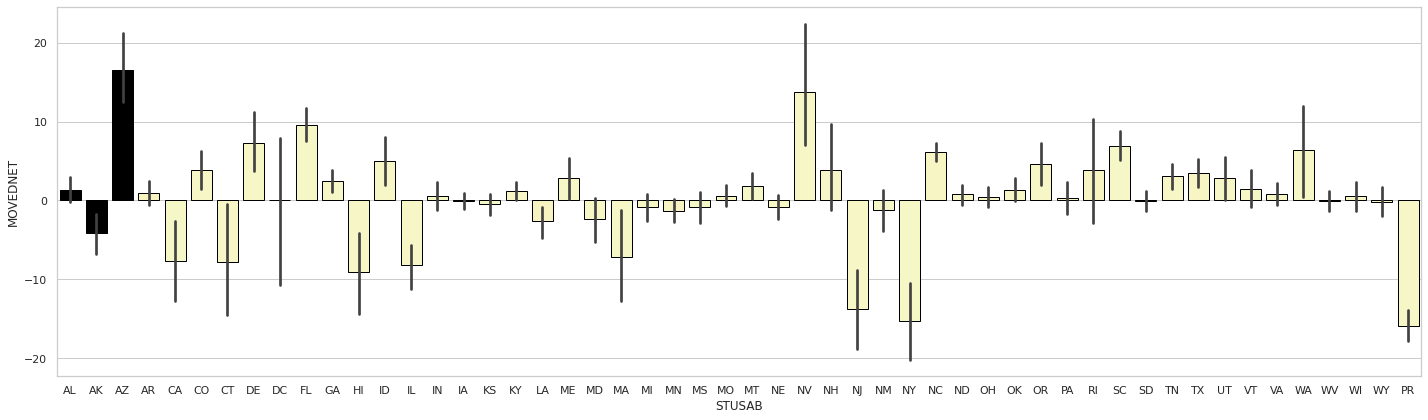

In [ ]:
import matplotlib

sns.set(rc={"figure.figsize":(20, 6)}, style = "whitegrid", color_codes = True)

cmap = matplotlib.cm.RdYlGn

norm = matplotlib.colors.Normalize(vmin=df.MOVEDNET.min(), vcenter=0, vmax=df.MOVEDNET.max())

colors = [matplotlib.pyplot.cm.RdYlGn(norm(c)) for c in df['MOVEDNET']]
ax = sns.barplot(x='STUSAB', y='MOVEDNET', data=df, palette=colors, edgecolor='black')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# Export CSV file
 - Use in other applicatins

In [ ]:
df_final.to_csv("/content/drive/MyDrive/W209_final_project/Data/migration_data_2016_2020.csv")

# Save Progress

In [ ]:
today = datetime.date.today()
today = datetime.date.strftime(today, "%Y%m%d")
pickler(df, path = "/content/drive/MyDrive/W209_final_project/Colab Notebooks", pklFileName="df_"+today+".pkl") # Added date to end YYYYMMDD

In [ ]:
pickler(df, path = "/content/drive/MyDrive/W209_final_project/Colab Notebooks", pklFileName="df_"+today+".pkl") # Added date to end YYYYMMDD

# Data from years 2010 - 2020

In [ ]:
"https://api.census.gov/data/2010/acs/flows?get=MOVEDIN,GEOID1,GEOID2,MOVEDOUT,FULL1_NAME,FULL2_NAME,MOVEDNET&for=county:*&in=state:36" # state and county are required for 2010

Buidling out the parameters to pass to requests

In [ ]:
def json_to_df(response):
  """ 

  """

  df = pd.DataFrame(response.json())
  df = df.rename(columns=df.iloc[0]).drop(df.index[0]) # replace column names with the first row

  return df

In [ ]:
from time import sleep
from tqdm.notebook import tqdm # progress bar library

In [ ]:
data = {}

In [121]:
variables = ["MOVEDIN",
    "GEOID1",
    "GEOID2",
    "MOVEDOUT",
    "FULL1_NAME",
    "FULL2_NAME",
    "MOVEDNET"
  ]

variables = ",".join(variables)
variables

'MOVEDIN,GEOID1,GEOID2,MOVEDOUT,FULL1_NAME,FULL2_NAME,MOVEDNET'

In [137]:
for y in tqdm(range(2010, 2022)):
  print("Adding year: ", y)

  if y in data.keys(): # skip over if the data is already there. 
    continue
  
  # create year url
  url = f"https://api.census.gov/data/{y}/acs/flows?" # can add back MOVEDIN,MOVEDOUT

  # change payload based on year
  if y < 2016: # loop over states since I can only  call one at a time apparently before 2016
    
    y_df = pd.DataFrame() # empty dataframe to store year data

    for s in tqdm(stateCodes["STATE"]):

      if s < 10: 
        s = "0"+str(s) # need two digit code
      payload = {"get": variables,"for": "county:*", "in":"state:"+str(s)}
      r = requests.get(url, params = payload)
      if r.status_code == 200:
        y_df = pd.concat([y_df, json_to_df(r)])

    # add year
    y_df["YEAR"] = y

    print(f"{y} dimensions {y_df.shape}")
    print("-" * 20)
    
    # write out data to larger dictionary
    data[y] = y_df
    
    del y_df

  else: 
    payload = {"get": variables,"for": "county:*"}
    r = requests.get(url, params = payload)
    
    if r.status_code == 200: # then add to the dataframe else skip
      y_df = json_to_df(r)
      y_df['YEAR'] = y

      print(f"{y} dimensions {y_df.shape}")
      print("-" * 20)

      data[y] = y_df
      del y_df
      
    else: 
      data[y] = ""
      


  0%|          | 0/12 [00:00<?, ?it/s]

Adding year:  2010
Adding year:  2011
Adding year:  2012
Adding year:  2013
Adding year:  2014
Adding year:  2015
Adding year:  2016
2016 dimensions (523811, 10)
--------------------
Adding year:  2017
2017 dimensions (517364, 10)
--------------------
Adding year:  2018
2018 dimensions (513337, 10)
--------------------
Adding year:  2019
2019 dimensions (505936, 10)
--------------------
Adding year:  2020
2020 dimensions (480130, 10)
--------------------
Adding year:  2021


In [139]:
type(df) != str

False

In [ ]:
# Join all the data together
df_final = pd.DataFrame()

for y, df in tqdm(data.items()):
  print("Adding year: ", y)
  if type(df) != str:
    df_final = pd.concat([df_final, df])
  
  del df

df_final.shape

In [145]:
# Cleanup final dataset
df_final.reset_index(drop = True, inplace = True)
df_final = df_final[df_final["MOVEDNET"].isnull() != True]
df_final = df_final.astype({"MOVEDNET":"int32", "state":"int32", "county":"int32"})
df_final = df_final.merge(stateCodes, how = "left", left_on = "state", right_on = "STATE")
print("DF shape: ", df_final.shape)
print("DF dtypes: ", df_final.dtypes)

In [151]:
today = datetime.date.today()
today = datetime.date.strftime(today, "%Y%m%d")
pickler(df_final,"/content/drive/MyDrive/W209_final_project/Data/PickleFiles/df_"+today+".pkl") # Added date to end YYYYMMDD

In [152]:
# Write out csv
df_final.to_csv("/content/drive/MyDrive/W209_final_project/Data/df_"+today+".csv")